In [533]:
import spacy
nlp = spacy.load('fr_core_news_sm')

In [316]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_selection import SelectKBest
from french_lefff_lemmatizer.french_lefff_lemmatizer import FrenchLefffLemmatizer
import nltk
from matplotlib import pyplot as plt

In [10]:
get_ipython().config.get('IPKernelApp', {})['parent_appname'] = ""

In [109]:
answers = pd.read_csv('raw/answers.csv', encoding="utf-8")
answers.head()

,customer_id,question_name,answer,theme
0,17 943,DC11,Dites leur la vérité. Si une situation est jug...,Démocratie et citoyenneté
1,17 965,DC11,Rendre la politique intéressante,Démocratie et citoyenneté
2,17 971,DC11,"Plus d'éducation civique, y compris au lycée. ...",Démocratie et citoyenneté
3,17 974,DC11,Information du citoyen + vote oblugatoire,Démocratie et citoyenneté
4,18 019,DC11,Qu'il arrête leur connerie comme les 80km/h,Démocratie et citoyenneté


# Construction d'un corpus en assemblant les réponses

corpus = ensemble des réponses mises bout à bout<br>
corpus_theme = ensemble des réponses mises bout à bout par thème

In [110]:
lemmatizer = FrenchLefffLemmatizer()

In [111]:
corpus = ""
for answer in answers['answer'][:]:
    nlp_answer = nlp(answer)
    for token in nlp_answer:
        corpus += lemmatizer.lemmatize(str(token)).replace('\n', ' ').replace('\r', '') + ' '

In [356]:
corpus_theme_full = dict()
for answer in answers[['answer', 'theme']].values:
    lemmatized_text = ''
    nlp_answer = nlp(answer[0])
    for token in nlp_answer:
        lemmatized_text += lemmatizer.lemmatize(str(token)).replace('\n', ' ').replace('\r', '') + ' '
    if answer[1] in corpus_theme_full:
        corpus_theme_full[answer[1]] += lemmatized_text
    else:
        corpus_theme_full[answer[1]] = lemmatized_text

# Construction d'un corpus en assemblant les réponses, en comptant une fois les mots par réponse

corpus = ensemble des réponses mises bout à bout<br>
corpus_theme = ensemble des réponses mises bout à bout par thème

In [371]:
corpus = ""
for answer in answers['answer'][:]:
    token_answer = set()
    nlp_answer = nlp(answer)
    for token in nlp_answer:
        token_answer.add(lemmatizer.lemmatize(str(token)))
    for token in token_answer:
        corpus += token + ' '

In [372]:
corpus_theme = dict()
for answer in answers[['answer', 'theme']].values:
    lemmatized_text = ''
    token_answer = set()
    nlp_answer = nlp(answer[0])
    for token in nlp_answer:
        token_answer.add(lemmatizer.lemmatize(str(token)))
    for token in token_answer:
        lemmatized_text += token + ' '
    if answer[1] in corpus_theme:
        corpus_theme[answer[1]] += lemmatized_text
    else:
        corpus_theme[answer[1]] = lemmatized_text

# Comparaison des corpus à l'aide d'un TFIDF

In [524]:
# listes des mots à retirer du tf_idf
stopwords_additionnel = [
    'les',
    'a',
    'plus',
    'faut',
    'tout',
    'tous',
    'prends',
    'tre',
    'si',
    'non',
    'doit',
    'avoir',
    'comme',
    'trop',
    'leurs',
    'faire',
    'ils',
    'peut',
    'bien',
    'aussi',
    'cela',
    'gens',
    'sans',
    'car',
    'très',
    'fait'
]

In [525]:
corpus = list(corpus_theme.values())
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(corpus)
print(X.shape)

(5, 21389)


In [529]:
tfidfvectorizer_unique = TfidfVectorizer(analyzer='word', 
                          token_pattern='[A-Za-z][\w\-]*', sublinear_tf=True, stop_words = stopwords.words('french') + stopwords_additionnel)

df_t = tfidfvectorizer_unique.fit_transform(list(corpus_theme.values()))

In [530]:
corpus_theme.keys()

dict_keys(['Démocratie et citoyenneté', 'Impôts et dépenses publiques', "Organisation de l'Etat", 'Contribution libre', 'Transition écologique'])

In [531]:
for i, theme in enumerate(corpus_theme.keys()):
    print(theme)
    print()
    print(top_feats_in_doc(df_t, tfidfvectorizer_unique.get_feature_names(), i))
    print()
    print()

Démocratie et citoyenneté

            feature     tfidf
0        migratoire  0.041640
1           sexisme  0.040653
2           racisme  0.036562
3           laïcité  0.035036
4        catholique  0.034416
5        homophobie  0.034085
6           coutume  0.033643
7          religion  0.032724
8    discrimination  0.032468
9           sexiste  0.031606
10        tolérance  0.030115
11            culte  0.029949
12             juif  0.029792
13         raciales  0.029792
14        religieux  0.029659
15     islamophobie  0.029580
16          raciale  0.029361
17     assimilation  0.029135
18       homosexuel  0.028901
19       homophobes  0.028659
20            voile  0.028249
21            arabe  0.028145
22      transphobie  0.027873
23             laïc  0.027292
24        sexuelles  0.027292
25           faciès  0.026982
26    comptabiliser  0.026982
27         ethnique  0.026656
28        tradition  0.026649
29            islam  0.026545
30      harcèlement  0.026438
31          c

## Visualisation des meilleurs mots à partir d'un graphe

In [349]:
def top_mean_feats(Xtr, features, grp_ids=None, min_tfidf=0.1, top_n=25):
    ''' Return the top n features that on average are most important amongst documents in rows
        indentified by indices in grp_ids. '''
    if grp_ids:
        D = Xtr[grp_ids].toarray()
    else:
        D = Xtr.toarray()

    D[D < min_tfidf] = 0
    tfidf_means = np.mean(D, axis=0)
    return top_tfidf_feats(tfidf_means, features, top_n)

In [350]:
def top_feats_by_class(Xtr, y, features, min_tfidf=0.1, top_n=25):
    ''' Return a list of dfs, where each df holds top_n features and their mean tfidf value
        calculated across documents with the same class label. '''
    dfs = []
    labels = np.unique(y)
    for label in labels:
        ids = np.where(y==label)
        feats_df = top_mean_feats(Xtr, features, ids, min_tfidf=min_tfidf, top_n=top_n)
        feats_df.label = label
        dfs.append(feats_df)
    return dfs

In [351]:
def plot_tfidf_classfeats_h(dfs):
    ''' Plot the data frames returned by the function plot_tfidf_classfeats(). '''
    fig = plt.figure(figsize=(12, 9), facecolor="w")
    x = np.arange(len(dfs[0]))
    for i, df in enumerate(dfs):
        ax = fig.add_subplot(1, len(dfs), i+1)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.set_frame_on(False)
        ax.get_xaxis().tick_bottom()
        ax.get_yaxis().tick_left()
        ax.set_xlabel("Mean Tf-Idf Score", labelpad=16, fontsize=14)
        ax.set_title("label = " + str(df.label), fontsize=16)
        ax.ticklabel_format(axis='x', style='sci', scilimits=(-2,2))
        ax.barh(x, df.tfidf, align='center', color='#3F5D7D')
        ax.set_yticks(x)
        ax.set_ylim([-1, x[-1]+1])
        yticks = ax.set_yticklabels(df.feature)
        plt.subplots_adjust(bottom=0.09, right=0.97, left=0.15, top=0.95, wspace=0.52)
    plt.show()

In [352]:
top_feats_by_class(df_t, corpus_theme.keys(), tfidfvectorizer_unique.get_feature_names(), min_tfidf=0.05, top_n=25)

/anaconda3/envs/elfrance/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  if __name__ == '__main__':


[           feature     tfidf
 0              les  0.649037
 1             plus  0.239146
 2                a  0.171434
 3         religion  0.135123
 4             faut  0.134218
 5         français  0.133012
 6   discrimination  0.127616
 7           france  0.126982
 8              tre  0.123536
 9        politique  0.123364
 10           faire  0.115955
 11            pays  0.114232
 12             mai  0.107685
 13            tout  0.104066
 14         citoyen  0.098036
 15        personne  0.096141
 16         racisme  0.095685
 17            vote  0.085459
 18           comme  0.084425
 19             ils  0.082529
 20         migrant  0.080807
 21              si  0.073398
 22         laïcité  0.072055
 23            doit  0.070641
 24            tous  0.070469]

/anaconda3/envs/elfrance/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  if __name__ == '__main__':


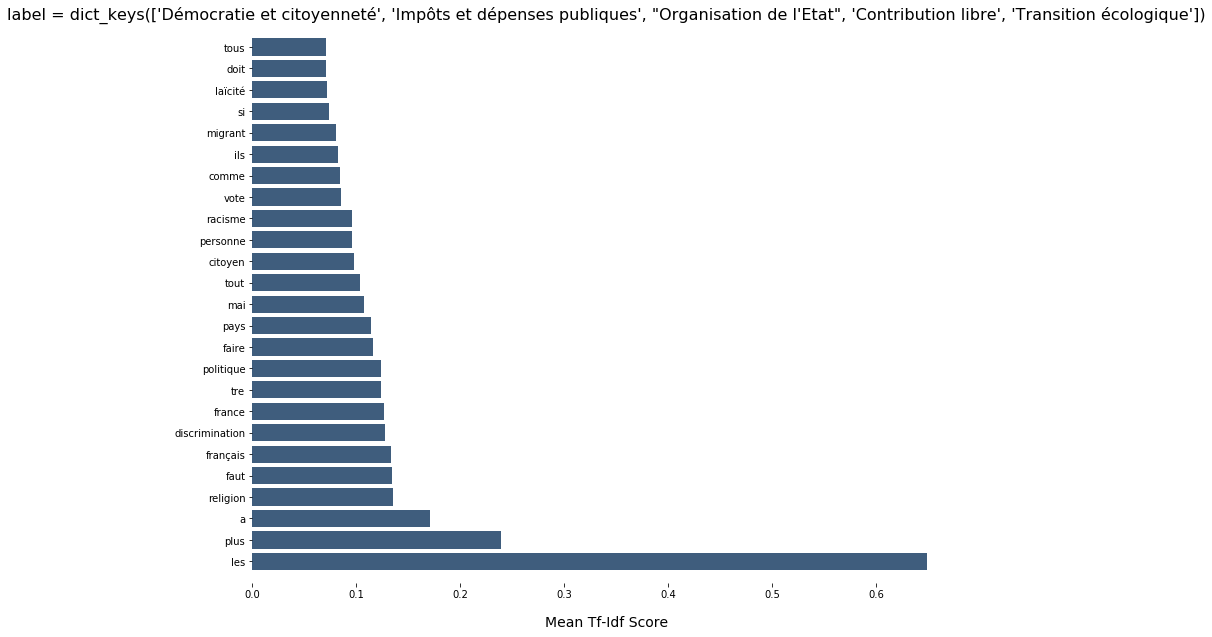

In [353]:
plot_tfidf_classfeats_h(top_feats_by_class(df_t, corpus_theme.keys(), tfidfvectorizer_unique.get_feature_names(), min_tfidf=0.05, top_n=25))

# Analyse du corpus sans assembler les réponses, en effectuant la moyenne des résultats par thème

In [376]:
answers.head()

,customer_id,question_name,answer,theme
0,17 943,DC11,Dites leur la vérité. Si une situation est jug...,Démocratie et citoyenneté
1,17 965,DC11,Rendre la politique intéressante,Démocratie et citoyenneté
2,17 971,DC11,"Plus d'éducation civique, y compris au lycée. ...",Démocratie et citoyenneté
3,17 974,DC11,Information du citoyen + vote oblugatoire,Démocratie et citoyenneté
4,18 019,DC11,Qu'il arrête leur connerie comme les 80km/h,Démocratie et citoyenneté


In [379]:
def lemmatize_answer(answer):
    lemmatized_answer = ''
    nlp_answer = nlp(answer)
    for token in nlp_answer:
        lemmatized_answer += lemmatizer.lemmatize(str(token)) + ' '
    return lemmatized_answer
    
answers['lemmatized_answer'] = answers['answer'] .apply(lemmatize_answer)

In [381]:
answers.to_csv('preprocessed/answers_lemmatized.csv', sep=';', encoding='utf-8', index=False)

In [486]:
corpus = list(answers['lemmatized_answer'])
tfidfvectorizer_unique = TfidfVectorizer(analyzer='word', 
                                         token_pattern='[A-Za-z][\w\-]*', 
                                         sublinear_tf=True, 
                                         stop_words = stopwords.words('french') + stopwords_additionnel,
                                         max_df=0.7
                                        )

df_t = tfidfvectorizer_unique.fit_transform(corpus)

In [487]:
def top_feats_in_doc_mean(Xtr, features, top_n=50):
    ''' Top tfidf features in specific document (matrix row) '''
    row = np.squeeze(np.asarray(Xtr))
    return top_tfidf_feats(row, features, top_n)

In [488]:
for theme in answers['theme'].unique():
    index_theme = answers.index[answers['theme'] == theme].tolist()
    df_theme = np.mean(df_t[index_theme], axis=0)
    print(theme)
    print()
    print(top_feats_in_doc_mean(df_theme, tfidfvectorizer_unique.get_feature_names()))
    print()
    print()

Démocratie et citoyenneté

           feature     tfidf
0         français  0.022076
1         religion  0.021680
2             vote  0.021511
3   discrimination  0.020144
4        politique  0.019780
5             pays  0.017988
6           france  0.017594
7          migrant  0.016717
8          racisme  0.016058
9          citoyen  0.014894
10          langue  0.013406
11        personne  0.013080
12        ducation  0.011899
13             mai  0.011854
14      homophobie  0.011766
15     obligatoire  0.011510
16         travail  0.011345
17            cole  0.011047
18           blanc  0.011047
19      accueillir  0.011036
20     immigration  0.010810
21     intégration  0.010556
22             loi  0.010540
23           femme  0.010492
24            gens  0.010244
25       religieux  0.010155
26        faudrait  0.010029
27         laïcité  0.009764
28         accueil  0.008504
29          rendre  0.007975
30         culture  0.007967
31          mettre  0.007937
32           pla